In [1]:
%matplotlib inline
import os
from pathlib import Path
from skimage import io
import cv2
import matplotlib.pyplot as plt
import numpy as np
from lxml import etree
from mxnet import image, nd
from skimage.transform import resize


In [2]:
input_height = 224
input_width = 224

PATH_TO_ROOT = str(Path.cwd().parent)
# parameters that you should set before running this script
filter = ['aeroplane', 'cat']       # select class, this default should yield 1489 training and 1470 validation images
voc_root_folder = PATH_TO_ROOT + "/data/VOCdevkit/" 
voc_dir = voc_root_folder + "VOC2009"
n_classes = len(filter) + 1 #+1 is for the background class

# Use this as a lookup for the colors and the classes  

# VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
#                 [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
#                 [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
#                 [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
#                 [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
#                 [0, 64, 128]]
# VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
#                'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
#                'diningtable', 'dog', 'horse', 'motorbike', 'person',
#                'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

VOC_COLORMAP_FILTER = [[0, 0, 0], [128, 0, 0], [64, 0, 0]]
VOC_CLASSES_FILTER = ['background', 'aeroplane', 'cat']


In [3]:
# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)
filtered_filenames = []
for a_f in annotation_files:
    tree = etree.parse(os.path.join(annotation_folder, a_f))
    if np.any([tag.text == filt for tag in tree.iterfind(".//name") for filt in filter]):
        filtered_filenames.append(a_f[:-4])

# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Main/")
classes_files = os.listdir(classes_folder)
train_files = [os.path.join(classes_folder, c_f) for filt in filter 
               for c_f in classes_files if filt in c_f and '_train.txt' in c_f]
val_files = [os.path.join(classes_folder, c_f) for filt in filter 
             for c_f in classes_files if filt in c_f and '_val.txt' in c_f]


In [4]:
def build_segmentation_dataset(list_of_files):
    temp = []
    for f_cf in list_of_files:
        with open(f_cf) as file:
            lines = file.read().splitlines()
            temp.append([line.split()[0] for line in lines if int(line.split()[-1]) == 1])
    train_filter = [item for l in temp for item in l]
    
    image_folder = os.path.join(voc_root_folder, "VOC2009/SegmentationClass/")
    segmentation_filter = [f for f in train_filter for file in os.listdir(image_folder) if f in file]
    
    features, labels = [None] * len(segmentation_filter), [None] * len(segmentation_filter)
    
    image_filenames = [os.path.join(image_folder, file) for f in segmentation_filter 
                           for file in os.listdir(image_folder) if f in file]

    for i, img_filename in enumerate(image_filenames):
        labels[i] = image.imread(img_filename)

    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in segmentation_filter 
                       for file in os.listdir(image_folder) if f in file]

    for i, img_filename in enumerate(image_filenames):
        features[i] = image.imread(img_filename)
    
    return features, labels


In [77]:
# train_features_raw = Images read from the folder JPEGImages, as ndarray
# train_segmentations_raw = Images read from the folder SegmentationCass, as ndarray
train_features_raw, train_segmentations_raw = build_segmentation_dataset(train_files)
validation_features_raw, validation_segmentations_raw = build_segmentation_dataset(val_files)


In [78]:
print(len(train_features_raw))
print(len(validation_features_raw))


48
53


In [6]:
def plot_ndarray(idx, features, labels):
    plt.subplot(121)
    plt.imshow(features[idx].asnumpy())
    plt.subplot(122)
    plt.imshow(labels[idx].asnumpy())
    plt.show()

def plot_pair(idx, features, labels):
    plt.subplot(121)
    plt.imshow(features[idx])
    plt.subplot(122)
    plt.imshow(labels[idx])
    plt.show()


(333, 500, 3)


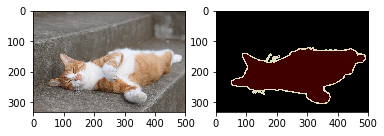

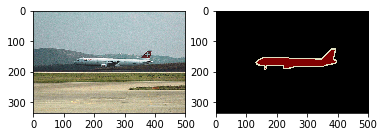

In [79]:
print(train_segmentations_raw[0].shape)
plot_ndarray(40, train_features_raw, train_segmentations_raw)
plot_ndarray(1, validation_features_raw, validation_segmentations_raw)


In [8]:
def convert_and_resize(data):
    converted_data = []
    for image in data:
        img = image.asnumpy()
        img = resize(img, (input_width, input_height)).astype('float32')
        converted_data.append(img)
    return np.array(converted_data)


train_features_resized = convert_and_resize(train_features_raw)
train_segmentations_resized = convert_and_resize(train_segmentations_raw)

validation_features_resized = convert_and_resize(validation_features_raw)
validation_segmentations_resized = convert_and_resize(validation_segmentations_raw)


In [9]:
print(train_features_resized.shape)
print(train_segmentations_resized.shape)
print(validation_features_resized.shape)
print(validation_segmentations_resized.shape)

(48, 224, 224, 3)
(48, 224, 224, 3)
(53, 224, 224, 3)
(53, 224, 224, 3)


In [74]:
# Save resized images to disk
PATH_TO_ROOT = str(Path.cwd().parent)
PATH_TO_DATASET = PATH_TO_ROOT + '/data/dataset/'
if not os.path.exists(PATH_TO_DATASET + 'segmentation/'):
    os.makedirs(PATH_TO_DATASET + 'segmentation/')
if not os.path.exists(PATH_TO_DATASET + 'segmentation/train'):
    os.makedirs(PATH_TO_DATASET + 'segmentation/train')
if not os.path.exists(PATH_TO_DATASET + 'segmentation/validation'):
    os.makedirs(PATH_TO_DATASET + 'segmentation/validation')
if not os.path.exists(PATH_TO_DATASET + 'segmentation/train-labels'):
    os.makedirs(PATH_TO_DATASET + 'segmentation/train-labels') 
if not os.path.exists(PATH_TO_DATASET + 'segmentation/validation-labels'):
    os.makedirs(PATH_TO_DATASET + 'segmentation/validation-labels')
if not os.path.exists(PATH_TO_DATASET + 'segmentation/processed_labels'):
    os.makedirs(PATH_TO_DATASET + 'segmentation/processed_labels')


In [ ]:
for i, img in enumerate(train_features_resized):
    name = PATH_TO_DATASET + 'segmentation/train/img' + str(i) + '.jpg'
    io.imsave(name, img)
    
for i, img in enumerate(validation_features_resized):
    name = PATH_TO_DATASET + 'segmentation/validation/img' + str(i) + '.jpg'
    io.imsave(name, img)
    
for i, img in enumerate(train_segmentations_resized):
    name = PATH_TO_DATASET + 'segmentation/train-labels/img' + str(i) + '.jpg'
    io.imsave(name, img)
    
for i, img in enumerate(validation_segmentations_resized):
    name = PATH_TO_DATASET + 'segmentation/validation-labels/img' + str(i) + '.jpg'
    io.imsave(name, img)


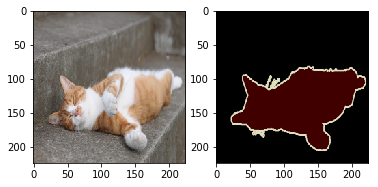

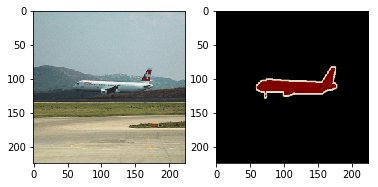

In [10]:
plot_pair(40, train_features_resized, train_segmentations_resized)
plot_pair(1, validation_features_resized, validation_segmentations_resized)

In [11]:
colormap2label = nd.zeros(256 ** 3)
for i, colormap in enumerate(VOC_COLORMAP_FILTER):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

    
def voc_label_indices(colormap, colormap2label):
    colormap = colormap.astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    return colormap2label[idx]


In [12]:
def getSegmentationArr( img, nClasses,  width, height):
    seg_labels = np.zeros((height, width , nClasses))
    img = cv2.resize(img, (width, height))
    img = img[:, :, 0]
    for c in range(nClasses):
        seg_labels[:, :, c] = (img == c).astype(int)
    return seg_labels


def get_segmentation_labels(segmentations):
    seg_labels = []
    for image in segmentations:
        img = voc_label_indices(image, colormap2label)
        img_stacked = np.dstack([img.asnumpy(), img.asnumpy(), img.asnumpy()])
        img_mod = getSegmentationArr (img_stacked, n_classes, 224, 224)
        seg_labels.append(img_mod)
    return seg_labels
        
        
train_seg_labels = get_segmentation_labels(train_segmentations_raw)
val_seg_labels = get_segmentation_labels(validation_segmentations_raw)


In [114]:
outfile_train = PATH_TO_DATASET + 'segmentation/processed_labels/train.npy'
np.save(outfile_train, train_seg_labels)
outfile_validation = PATH_TO_DATASET + 'segmentation/processed_labels/validation.npy'
np.save(outfile_validation, val_seg_labels)

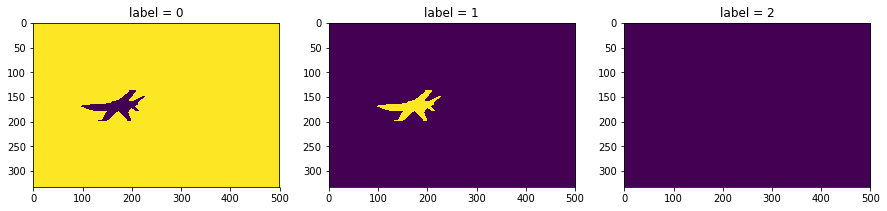

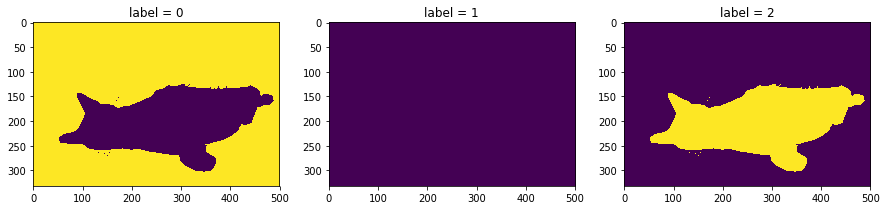

In [112]:
# Plot segmentations (sanity check)
def plot_segmentation(idx):
    img = voc_label_indices(train_segmentations_raw[idx], colormap2label).asnumpy()
#     img = train_seg_labels[0]
    mi, ma = 0, 2
    n_classes_plot = 3
    fig = plt.figure(figsize=(15,10))
    for k in range(mi, ma+1):
        ax = fig.add_subplot(1, n_classes_plot, k+1)
        ax.imshow((img == k)*1.0)
        ax.set_title("label = {}".format(k))
        
plot_segmentation(1)
plot_segmentation(40)

# Develop deep learning FCN model
##### It deplicates VGG16 net by discarding the final classifier layer and convert all fully connected layers to convolutions.

In [14]:
## Import usual libraries
from keras.models import *
from keras.layers import *
warnings.filterwarnings("ignore")

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 1
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.95
# config.gpu_options.visible_device_list = "0" 
# set_session(tf.Session(config=config))   


Using TensorFlow backend.


In [15]:
## location of VGG weights
VGG_Weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"


In [16]:
def FCN8( nClasses,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) 
    ## is operated 5 times,which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING = "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', 
               data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', 
               data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1',
               data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2',
               data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1',
               data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2',
               data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3',
               data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1',
               data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2',
               data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3',
               data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1',
               data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2',
               data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3',
               data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    #x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fc1')(x)
    # <--> o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(4096, activation='relu', name='fc2')(x)
    # <--> o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)   
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(1000 , activation='softmax', name='predictions')(x)
    # <--> o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    
    vgg  = Model(  img_input , pool5  )
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", 
                 data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7",
                 data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same',
                       name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) ,
                                 use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

model = FCN8(nClasses     = n_classes,  
             input_height = input_height, 
             input_width  = input_width)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [18]:
X_train = train_features_resized
y_train = np.array(train_seg_labels)
X_test = validation_features_resized
y_test = np.array(val_seg_labels)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(48, 224, 224, 3) (48, 224, 224, 2)
(48, 224, 224, 3) (48, 224, 224, 2)


In [19]:
from keras import optimizers

sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist1 = model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=1,epochs=1,verbose=2)


Train on 48 samples, validate on 48 samples
Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[7,7,512,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training/SGD/Variable_26/Assign (defined at C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\keras\backend\tensorflow_backend.py:400)  = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/SGD/Variable_26, training/SGD/zeros_26)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training/SGD/Variable_26/Assign', defined at:
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-56f2880fee32>", line 10, in <module>
    batch_size=1,epochs=1,verbose=2)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\keras\engine\training.py", line 1008, in fit
    self._make_train_function()
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\keras\engine\training.py", line 498, in _make_train_function
    loss=self.total_loss)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\keras\optimizers.py", line 193, in get_updates
    moments = [K.zeros(shape) for shape in shapes]
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\keras\optimizers.py", line 193, in <listcomp>
    moments = [K.zeros(shape) for shape in shapes]
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\keras\backend\tensorflow_backend.py", line 702, in zeros
    return variable(v, dtype=dtype, name=name)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\keras\backend\tensorflow_backend.py", line 400, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\ops\variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\ops\variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\ops\variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\ops\variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\ops\variables.py", line 1329, in __init__
    constraint=constraint)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\ops\variables.py", line 1481, in _init_from_args
    validate_shape=validate_shape).op
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\ops\state_ops.py", line 221, in assign
    validate_shape=validate_shape)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 61, in assign
    use_locking=use_locking, name=name)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[7,7,512,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training/SGD/Variable_26/Assign (defined at C:\Users\teodo\Anaconda3\envs\ComputerVision\lib\site-packages\keras\backend\tensorflow_backend.py:400)  = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/SGD/Variable_26, training/SGD/zeros_26)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()